<a href="https://colab.research.google.com/github/hanseungsoo13/Pytorch-Study/blob/main/%EB%82%98%EB%A7%8C%EC%9D%98_Pytorch_%EB%AA%A8%EB%8D%B8_%EC%9E%91%EC%84%B1_%EB%B0%A9%EC%8B%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch import optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

In [3]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


In [4]:
!kaggle datasets download -d tongpython/cat-and-dog
!unzip cat-and-dog.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: training_set/training_set/cats/cat.3704.jpg  
  inflating: training_set/training_set/cats/cat.3705.jpg  
  inflating: training_set/training_set/cats/cat.3706.jpg  
  inflating: training_set/training_set/cats/cat.3707.jpg  
  inflating: training_set/training_set/cats/cat.3708.jpg  
  inflating: training_set/training_set/cats/cat.3709.jpg  
  inflating: training_set/training_set/cats/cat.371.jpg  
  inflating: training_set/training_set/cats/cat.3710.jpg  
  inflating: training_set/training_set/cats/cat.3711.jpg  
  inflating: training_set/training_set/cats/cat.3712.jpg  
  inflating: training_set/training_set/cats/cat.3713.jpg  
  inflating: training_set/training_set/cats/cat.3714.jpg  
  inflating: training_set/training_set/cats/cat.3715.jpg  
  inflating: training_set/training_set/cats/cat.3716.jpg  
  inflating: training_set/training_set/cats/cat.3717.jpg  
  inflating: training_set/training_set/cats/cat.3718.jpg  
  inflating: training

In [5]:
train_data_dir = 'training_set/training_set'
test_data_dir = 'test_set/test_set'

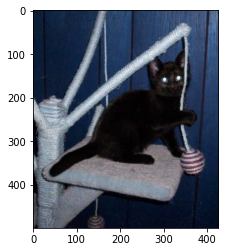

In [13]:
plt.imshow(cv2.imread(cats[0]))

In [45]:
cv2.imread(cats[0])[:,:,::-1]

array([[[ 53,  31,   8],
        [ 56,  34,  11],
        [ 56,  33,  15],
        ...,
        [139, 102,  75],
        [144, 107,  80],
        [145, 108,  81]],

       [[ 54,  32,   9],
        [ 57,  35,  12],
        [ 56,  33,  15],
        ...,
        [138, 101,  74],
        [144, 107,  80],
        [145, 108,  81]],

       [[ 54,  32,   9],
        [ 57,  35,  12],
        [ 56,  33,  15],
        ...,
        [142, 105,  78],
        [147, 110,  83],
        [148, 111,  84]],

       ...,

       [[ 78,  72,  74],
        [ 68,  62,  64],
        [ 58,  52,  56],
        ...,
        [ 37,   8,   0],
        [ 37,   8,   0],
        [ 37,   8,   0]],

       [[ 72,  66,  68],
        [ 60,  54,  56],
        [ 48,  42,  46],
        ...,
        [ 37,   8,   0],
        [ 37,   8,   0],
        [ 37,   8,   0]],

       [[ 68,  62,  64],
        [ 54,  48,  50],
        [ 40,  34,  38],
        ...,
        [ 37,   8,   0],
        [ 37,   8,   0],
        [ 37,   8,   0]]

In [8]:
cats[0]

'training_set/training_set/cats/cat.259.jpg'

In [59]:
class Catsdogs(Dataset):
  def __init__(self, folder):
      cats = glob(folder+'/cats/*.jpg')
      dogs = glob(folder+'/dogs/*.jpg')
      self.fpaths = cats + dogs
      from random import shuffle, seed; seed(10); shuffle(self.fpaths)
      self.targets = [fpath.split('/')[-1].startswith('dog') for fpath in self.fpaths] # dog=1 & cat=0 #파일의 위치를 알려줌
  def __len__(self): 
    return len(self.fpaths)
  def __getitem__(self, ix):
    f = self.fpaths[ix]
    target = self.targets[ix] #타겟을 따로 받아줌
    im = (cv2.imread(f))
    im = cv2.resize(im, (224,224)) #이미지 리사이즈
    return torch.tensor(im/255).permute(2,0,1).to(device).float(), torch.tensor([target]).float().to(device)

In [60]:
data=Catsdogs(test_data_dir)

In [123]:
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 입력 이미지 채널 1개, 출력 채널 6개, 5x5의 정사각 컨볼루션 행렬
        # 컨볼루션 커널 정의
        self.conv1 = nn.Conv2d(3, 6, 4)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # 아핀(affine) 연산: y = Wx + b
        self.fc1 = nn.Linear(44944, 32)  # 5*5은 이미지 차원에 해당
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        # (2, 2) 크기 윈도우에 대해 맥스 풀링(max pooling)
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # 크기가 제곱수라면, 하나의 숫자만을 특정(specify)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # 배치 차원을 제외한 모든 차원을 하나로 평탄화(flatten)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.sig(x)
 
        return x


net = Net()
print(net)


Net(
  (conv1): Conv2d(3, 6, kernel_size=(4, 4), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=44944, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [124]:
model = Net()
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)

In [125]:
def get_data():     
    train = Catsdogs(train_data_dir)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last = True)
    val = Catsdogs(test_data_dir)
    val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last = True)
    return trn_dl, val_dl

In [135]:
def train_batch(x,y,model,loss_fn,optimizer):
  model.train()
  prediction = model(x)
  batch_loss = loss_fn(prediction,y)
  batch_loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    prediction = model(x)
    is_correct = (prediction > 0.5) == y #0.5보다크면 y와 같다고 하겠따
    return is_correct.cpu().numpy().tolist()

In [136]:
@torch.no_grad()
def val_loss(x, y, model):
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [137]:
trn_dl, val_dl = get_data()

In [138]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    for ix, batch in enumerate(iter(trn_dl)):
        #print(ix)
        x, y = batch
        batch_loss = train_batch(x, y, model, loss_fn, optimizer)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
        #validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    #val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1


KeyboardInterrupt: ignored

In [ ]:
trn_dl